Testing with n_neighbors = 5
Skipping n_neighbors=5 due to lack of class diversity.
Testing with n_neighbors = 10
Random Forest accuracy with n_neighbors=10: 0.486195601310248
Logistic Regression accuracy with n_neighbors=10: 0.5896116050538137
SVM accuracy with n_neighbors=10: 0.5896116050538137
Decision Tree accuracy with n_neighbors=10: 0.5009358914365933
K-Nearest Neighbors accuracy with n_neighbors=10: 0.5009358914365933
Gradient Boosting accuracy with n_neighbors=10: 0.5009358914365933
Testing with n_neighbors = 20
Random Forest accuracy with n_neighbors=20: 0.9052409920449228
Logistic Regression accuracy with n_neighbors=20: 0.5896116050538137
SVM accuracy with n_neighbors=20: 0.5896116050538137
Decision Tree accuracy with n_neighbors=20: 0.8259241927936359
K-Nearest Neighbors accuracy with n_neighbors=20: 0.7788956481048198
Gradient Boosting accuracy with n_neighbors=20: 0.8724847917641554
Testing with n_neighbors = 30
Random Forest accuracy with n_neighbors=30: 0.9763687412260

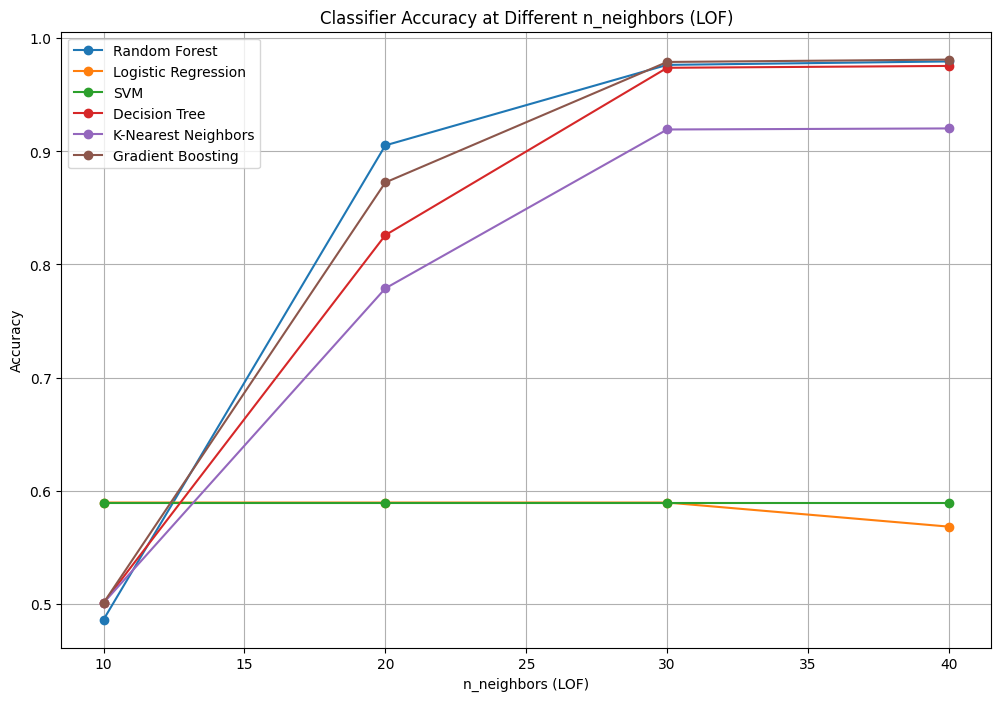

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('Featured_dataset.csv')

# Convert 'Time' column to Unix timestamp (seconds) if it exists
if 'Time' in data.columns:
    data['Time'] = pd.to_datetime(data['Time']).astype('int64') // 10**9

# Drop or transform any non-numeric columns and set 'label' as target column
X = data.drop(columns=['label'])  # Features, replace 'label' if necessary
y = data['label']  # Target variable, replace 'label' if necessary

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Classifiers to evaluate
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Range of n_neighbors for LOF
n_neighbors_range = [5, 10, 20, 30, 40]

# Dictionary to store accuracy results
accuracy_results = {name: [] for name in classifiers.keys()}

# Evaluate each classifier at different n_neighbors values
for n_neighbors in n_neighbors_range:
    print(f"Testing with n_neighbors = {n_neighbors}")
    
    # Apply Local Outlier Factor (LOF) on the training data
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    lof.fit(X_train)
    lof_scores = lof.negative_outlier_factor_
    
    # Filter out outliers
    X_train_filtered = X_train[lof_scores > np.percentile(lof_scores, 5)]
    y_train_filtered = y_train[lof_scores > np.percentile(lof_scores, 5)]
    
    # Check if both classes are present after filtering
    if len(np.unique(y_train_filtered)) < 2:
        print(f"Skipping n_neighbors={n_neighbors} due to lack of class diversity.")
        for name in classifiers.keys():
            accuracy_results[name].append(None)  # Append None for skipped values
        continue
    
    # Test each classifier
    for name, clf in classifiers.items():
        clf.fit(X_train_filtered, y_train_filtered)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_results[name].append(accuracy)
        print(f"{name} accuracy with n_neighbors={n_neighbors}: {accuracy}")

# Plot results
plt.figure(figsize=(12, 8))
for name, accuracies in accuracy_results.items():
    valid_indices = [i for i, acc in enumerate(accuracies) if acc is not None]
    valid_n_neighbors = [n_neighbors_range[i] for i in valid_indices]
    valid_accuracies = [accuracies[i] for i in valid_indices]
    plt.plot(valid_n_neighbors, valid_accuracies, marker='o', label=name)

plt.xlabel("n_neighbors (LOF)")
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy at Different n_neighbors (LOF)")
plt.legend()
plt.grid(True)
plt.show()
